# NLP Crash Course - Part 1: Data Preparation
Prepared by: Nickolas Freeman, PhD

In this notebook, we will begin looking at how we can use Python for Natural Language Processing (NLP). From https://en.wikipedia.org/wiki/Natural_language_processing:
> Natural language processing (NLP) is a subfield of linguistics, computer science, information engineering, and artificial intelligence concerned with the interactions between computers and human (natural) languages, in particular how to program computers to process and analyze large amounts of natural language data.

The following code block imports some libraries that we will be using.

In [1]:
# Libraries that are part of the Python standard library
import gzip
import itertools
import json
import pathlib
import string
import time

# Third-party packages
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

As with almost all analytical efforts, the quality of a model or application will be largely dependent on the quality of the data used for the analysis. Thus, the focus of this notebook will be on demonstrating how we can use the **Natural Language Toolkit (NLTK)** to prepare a *corpus* of text data for analysis. From https://www.kdnuggets.com/2017/11/building-wikipedia-text-corpus-nlp.html:
> One of the first things required for natural language processing (NLP) tasks is a corpus. In linguistics and NLP, corpus (literally Latin for body) refers to a collection of texts.

We will be using the `nltk` library for our data preparation. If you have not worked with `nltk` before, you will need to run the `nltk.download()` function to download additional resources used by the library. You can do this using the following code block by setting the value of the `run_nltk_downloader` variable to `True`.

In [2]:
run_nltk_downloader = False

if run_nltk_downloader:
    nltk.download()

The data we will be using was harvested from the twitter API (see https://developer.twitter.com/en/docs for more information). The data is stored in JSON (JavaScript Object Notation) format. The JSON file is compressed using GZIP compression (see https://en.wikipedia.org/wiki/Gzip for more information) to save disk space. The following code block demonstrates how to read the data.

In [3]:
# create a pathlib.Path object for the data
raw_data_filepath = pathlib.Path('relevant_data.json.gz')

# open the data filepath
with gzip.GzipFile(raw_data_filepath, 'r') as fp:
    
    # read the bytes from the datafile
    json_bytes = fp.read()
    
    # decode the bytes to utf-8
    json_str = json_bytes.decode('utf-8')
    
    # load the decoded bytes as JSON
    tweet_data = json.loads(json_str)
    
print(f'The data includes {len(tweet_data)} observations.')

The data includes 434578 observations.


The data is stored as a list of lists. Each sublist has six items:
1. the datetime for the tweet,
2. the username associated with the tweet,
3. the user associated with the tweet,
4. the location associated with the tweet,
5. the language associated with the tweet, and
6. the tweet text.

The following code block prints the first entry as an example.

In [4]:
print(tweet_data[0])

['Sat Mar 28 08:21:12 +0000 2020', 'DianeB67082104', 'Diane B', 'Yorkshire and The Humber', 'en', '@redviking_82 Yea we are fine staying home as much as we can Hubby has to go to work (keyworker food production) and we shop for his parents I stay in the car. His Mum likes to see me ❤️ Stay safe love xx']


The following code block:
1. creates a Pandas `DataFrame` with the data (named `tweet_df`),
2. converts the `Datetime` column to a datetime format,
3. creates a `Date` column with just the date extracted from the `Datetime` column,
4. creates a `Day_Name` column that specifies the day of the week that the tweet was posted.
5. creates a `Weekend` column that is `True` if the tweet was posted on a weekend, and `False` otherwise.

In [5]:
column_names = [
    'Datetime',
    'Username',
    'User',
    'Location',
    'Language',
    'Text',
]

tweet_df = pd.DataFrame(tweet_data, 
                        columns = column_names)

tweet_df['Datetime'] = pd.to_datetime(tweet_df['Datetime'], 
                                      format = '%a %b %d %H:%M:%S %z %Y')
tweet_df['Date'] = tweet_df['Datetime'].dt.date
tweet_df['Day_Name'] = tweet_df['Datetime'].dt.day_name()

weekend_mask = tweet_df['Day_Name'].isin(['Saturday', 'Sunday'])
tweet_df.loc[weekend_mask, 'Weekend'] = True
tweet_df.loc[~weekend_mask, 'Weekend'] = True

tweet_df['Hour'] = tweet_df['Datetime'].dt.hour
tweet_df.head()

,Datetime,Username,User,Location,Language,Text,Date,Day_Name,Weekend,Hour
0,2020-03-28 08:21:12+00:00,DianeB67082104,Diane B,Yorkshire and The Humber,en,@redviking_82 Yea we are fine staying home as ...,2020-03-28,Saturday,True,8
1,2020-03-28 09:07:14+00:00,BiotechPolicyUK,Michael M. Hopkins,"Brighton, UK",en,This is a helpful analysis of NERVTAG delibera...,2020-03-28,Saturday,True,9
2,2020-03-28 00:14:05+00:00,MarketingEdgeM,Marketing Edge,"Lagos, Nigeria",en,"Kantar, the world’s leading data, insights and...",2020-03-28,Saturday,True,0
3,2020-03-28 05:36:36+00:00,Mrtroublelex,Raynomics,"Warri, Nigeria",en,"@iRuntown__ I been like you well well, but all...",2020-03-28,Saturday,True,5
4,2020-03-28 11:10:05+00:00,whitedragoncom,Kin Dle,None,en,Jesus Christ Christian Bible Prophecy News - F...,2020-03-28,Saturday,True,11


The earlier code block shows that our data includes hundreds of thousands of tweets. For the sake of time, we will only work with a random sample of these tweets when demonstrating the data preparation steps. The following code block shows how we can use `numpy` to obtain a random sample of the tweets. **Note:** Specifying the `seed` for the random number generator allows us to draw *consistent* random samples. The first tweet in the sample is printed.

In [6]:
np.random.seed(0)
sample_size = 1000
sample = np.random.choice(tweet_df['Text'].tolist(), 
                          size = sample_size,
                          replace = False,
                         )
sample = sample.tolist()
print(sample[0])

@olandgren Dementia means my Dad has to listen to my Mother's questions all day about what is happening. She is still confused about COVID. She certainly does not understand the rioting.


A common first step in data preparation for NLP is tokenization. From https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/:
> Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.

In this notebook, we will be focusing on tokenizing the tweets into words or phrases (n-grams). We will begin with word tokenization. A obvious approach to such tokenization is splitting texts (tweets in our case) by spaces. The following code block shows how we can do this for the first tweet using Python's builtin `split` method for strings.

In [7]:
current_tweet = sample[0]
print(current_tweet.split())

['@olandgren', 'Dementia', 'means', 'my', 'Dad', 'has', 'to', 'listen', 'to', 'my', "Mother's", 'questions', 'all', 'day', 'about', 'what', 'is', 'happening.', 'She', 'is', 'still', 'confused', 'about', 'COVID.', 'She', 'certainly', 'does', 'not', 'understand', 'the', 'rioting.']


Our simple tokenization method of splitting on spaces works perfectly for the first tweet. However, let's consider another example where the tweet includes emojis.

In [8]:
current_tweet = sample[2]
print(current_tweet.split())

['@chrissyteigen', 'I’m', 'a', 'Native', 'American', 'living', 'on', 'a', 'reservation', 'in', '#Manitoba', '#Indigenous', 'we', 'love', 'you', '😍', '❤️🇨🇦👩🏽\u200d🍳👩🏽\u200d🍳👩🏽\u200d🍳👩🏽\u200d🍳👩🏽\u200d🍳👩🏽\u200d🍳🌹#StaySafeStayHome', '#food', '#TopChef']


As you can see, our space-splitting method does not perform as well in this case. This is where the `nltk` library can be helpful. In particular, the library includes several *tokenizers* that can be employed and customized to improve tokenization for a given task. The following code block shows the various tokenizers that are available in the `nltk.tokenize` module. Of particular interest for us, note that the module includes a `TweetTokenizer`.

In [9]:
print(dir(nltk.tokenize))

['BlanklineTokenizer', 'LineTokenizer', 'MWETokenizer', 'NLTKWordTokenizer', 'PunktSentenceTokenizer', 'RegexpTokenizer', 'ReppTokenizer', 'SExprTokenizer', 'SpaceTokenizer', 'StanfordSegmenter', 'SyllableTokenizer', 'TabTokenizer', 'TextTilingTokenizer', 'ToktokTokenizer', 'TreebankWordTokenizer', 'TweetTokenizer', 'WhitespaceTokenizer', 'WordPunctTokenizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_treebank_word_tokenizer', 'api', 'blankline_tokenize', 'casual', 'casual_tokenize', 'destructive', 'line_tokenize', 'load', 'mwe', 'punkt', 're', 'regexp', 'regexp_span_tokenize', 'regexp_tokenize', 'repp', 'sent_tokenize', 'sexpr', 'sexpr_tokenize', 'simple', 'sonority_sequencing', 'stanford_segmenter', 'string_span_tokenize', 'texttiling', 'toktok', 'treebank', 'util', 'word_tokenize', 'wordpunct_tokenize']


The following code block shows how we can use the `TweetTokenizer` to tokenize the previous example.

In [10]:
current_tweet = sample[2]
tknzr = nltk.tokenize.TweetTokenizer()
print(tknzr.tokenize(current_tweet))

['@chrissyteigen', 'I', '’', 'm', 'a', 'Native', 'American', 'living', 'on', 'a', 'reservation', 'in', '#Manitoba', '#Indigenous', 'we', 'love', 'you', '😍', '❤', '️', '🇨', '🇦', '👩', '🏽', '\u200d', '🍳', '👩', '🏽', '\u200d', '🍳', '👩', '🏽', '\u200d', '🍳', '👩', '🏽', '\u200d', '🍳', '👩', '🏽', '\u200d', '🍳', '👩', '🏽', '\u200d', '🍳', '🌹', '#StaySafeStayHome', '#food', '#TopChef']


The following code block shows how we can apply the `TweetTokenizer` to all of the tweets in our sample, storing the the tokens for each tweet in a list object named `tweet_tokens`. **Note** that applying the tokenizer to a single tweet returned a list of all the tokensin the tweet. Thus, our `tweet_tokens` object will be a list of lists, where each sublist specifies the tokens for a single tweet.

After constructing the `tweet_tokens` object, we construct a list of all tokens and use the `nltk.FreqDist` function to identify the 30 tokens that occur most frequently in the sample of tweets.

In [11]:
tweet_tokens = [tknzr.tokenize(current_tweet) for current_tweet in sample]
all_tokens = list(itertools.chain.from_iterable(tweet_tokens))
freq_dist = nltk.FreqDist(all_tokens)
freq_dist.most_common(30)

[('.', 1495),
 ('the', 1147),
 (',', 1043),
 ('to', 959),
 ('and', 830),
 ('of', 655),
 ('a', 554),
 ('in', 477),
 ('is', 427),
 ('for', 393),
 ('-', 388),
 ('I', 343),
 ('’', 333),
 ('19', 306),
 ('are', 302),
 ('COVID', 289),
 ('!', 280),
 ('you', 265),
 ('it', 255),
 ('that', 251),
 ('?', 247),
 ('food', 246),
 ('on', 225),
 ('with', 220),
 ('have', 210),
 ('this', 200),
 ('not', 185),
 (':', 172),
 ('Covid', 171),
 ('be', 169)]

Inspecting the most common 30 tokens reveals some potential issues. First, many of the most common tokens are punctuation symbols. Second, we observe some inconsistencies due to spelling case, e.g., COVID vs. Covid. Third, we observe many words that may not necessarily be too informative with regard to understanding a particular text, e.g., the, and, etc. 

We will now work to handle these issues, starting with punctuation. For this purpose, we will use the `string` library. The following code block shows how we can use the library to get a string that contains common punctuation symbols.

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Note that we can use the `in` comparison operator to see if a specific character is in the common punctuation string.

In [13]:
'.' in string.punctuation

True

Similarly, the `nltk` library includes a list of stopwords that we can use to remove common words that add little additional information to texts. The following code block shows how we can access the list of common stopwords for the English language using `nltk`.

In [14]:
print(nltk.corpus.stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

As we did for punctuation, we can use the `in` comparison operator to see if a string is a stopword.

In [15]:
'the' in nltk.corpus.stopwords.words('english')

True

The following code block contains a revised tokenization process that handles the three previously identified issues, using the builtin `lower` method for strings to handle the spelling case issues.

In [16]:
tweet_tokens = []
for current_tweet in sample:
    # tokenize a lower-cased version of the tweet
    current_tokens = tknzr.tokenize(current_tweet.lower())
    
    # remove puntuation
    current_tokens = [current_token for current_token in current_tokens if current_token not in string.punctuation]
    
    # remove stopwords
    current_tokens = [current_token for current_token in current_tokens if current_token not in nltk.corpus.stopwords.words('english')]
    tweet_tokens.append(current_tokens)
    
all_tokens = list(itertools.chain.from_iterable(tweet_tokens))
freq_dist = nltk.FreqDist(all_tokens)
freq_dist.most_common(30)

[('covid', 565),
 ('’', 333),
 ('19', 306),
 ('food', 278),
 ('people', 130),
 ('...', 128),
 ('get', 93),
 ('like', 82),
 ('us', 82),
 ('one', 60),
 ('help', 59),
 ('time', 55),
 ('even', 54),
 ('pandemic', 54),
 ('deaths', 54),
 ('still', 53),
 ('..', 51),
 ('think', 50),
 ('need', 49),
 ('trump', 49),
 ('would', 48),
 ('health', 47),
 ('#covid19', 47),
 (':/', 47),
 ('good', 46),
 ('new', 45),
 ('many', 44),
 ('see', 44),
 ('virus', 44),
 ('cases', 43)]

Although this is better, we can still make some improvements by defining custom stopwords to catch some of the less traditional strings we observe. This is done in the following code block.

In [17]:
my_stopwords = nltk.corpus.stopwords.words('english')
my_stopwords.extend(['..', '...', 'get'])

tweet_tokens = []
for current_tweet in sample:
    current_tokens = tknzr.tokenize(current_tweet.lower())
    current_tokens = [current_token for current_token in current_tokens if current_token not in string.punctuation]
    current_tokens = [current_token for current_token in current_tokens if current_token not in my_stopwords]
    tweet_tokens.append(current_tokens)
    
all_tokens = list(itertools.chain.from_iterable(tweet_tokens))
freq_dist = nltk.FreqDist(all_tokens)
freq_dist.most_common(30)

[('covid', 565),
 ('’', 333),
 ('19', 306),
 ('food', 278),
 ('people', 130),
 ('like', 82),
 ('us', 82),
 ('one', 60),
 ('help', 59),
 ('time', 55),
 ('even', 54),
 ('pandemic', 54),
 ('deaths', 54),
 ('still', 53),
 ('think', 50),
 ('need', 49),
 ('trump', 49),
 ('would', 48),
 ('health', 47),
 ('#covid19', 47),
 (':/', 47),
 ('good', 46),
 ('new', 45),
 ('many', 44),
 ('see', 44),
 ('virus', 44),
 ('cases', 43),
 ('please', 42),
 ('know', 42),
 ('home', 41)]

This last list looks better. **By the way, did you notice the speed difference between the previous two code blocks? What is happening?**

Although it is not evident in the previous list of common tokens, there is another issue that might cause some problems. In particular, notice that the list includes the words *deaths* and *cases*, which are the plural forms of *death* and *case*. Should we consider the singular and plural forms of words as different words? Typically, we use a technique called lemmatization to handle such cases. From https://en.wikipedia.org/wiki/Lemmatisation:
> Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

Again, `nltk` comes to the rescue with several *lemmatizers* built in. The following code block shows how we can instantiate a lemmatizer.

In [18]:
lemmatizer = nltk.stem.WordNetLemmatizer() 

The following code block shows how we can use the `lemmatize` method of the instantiated lemmatizer to lemmatize the first tweet in our sample.

In [19]:
for token in tweet_tokens[0]:
    print(f'Token: {token} -> {lemmatizer.lemmatize(token)}')

Token: @olandgren -> @olandgren
Token: dementia -> dementia
Token: means -> mean
Token: dad -> dad
Token: listen -> listen
Token: mother's -> mother's
Token: questions -> question
Token: day -> day
Token: happening -> happening
Token: still -> still
Token: confused -> confused
Token: covid -> covid
Token: certainly -> certainly
Token: understand -> understand
Token: rioting -> rioting


We can go further by reducing lemmatized tokens to their respective stems. From https://en.wikipedia.org/wiki/Stemming:
>stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root.

Again, `nltk` has a variety of builtin *stemmers*. The following code block instantiates a popular stemmer, the *Porter* stemmer.

In [20]:
stemmer = nltk.stem.porter.PorterStemmer()

The following code block applies the stemmer to our lemmatized tokens.

In [21]:
for token in tweet_tokens[0]:
    lemma = lemmatizer.lemmatize(token)
    stem = stemmer.stem(lemma)
    print(f'Token: {token} -> {lemma} -> {stem}')

Token: @olandgren -> @olandgren -> @olandgren
Token: dementia -> dementia -> dementia
Token: means -> mean -> mean
Token: dad -> dad -> dad
Token: listen -> listen -> listen
Token: mother's -> mother's -> mother'
Token: questions -> question -> question
Token: day -> day -> day
Token: happening -> happening -> happen
Token: still -> still -> still
Token: confused -> confused -> confus
Token: covid -> covid -> covid
Token: certainly -> certainly -> certainli
Token: understand -> understand -> understand
Token: rioting -> rioting -> riot


The following code block defines a function that we can use to apply all of our data preparation techniques a list of tweets.

In [22]:
def prepare_texts(list_of_texts):
    my_stopwords = nltk.corpus.stopwords.words('english')
    my_stopwords.extend(['..', '...', 'get'])
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stemmer = nltk.stem.porter.PorterStemmer()

    tokens = []
    for current_text in list_of_texts:
        current_tokens = tknzr.tokenize(current_text.lower())
        current_tokens = [current_token for current_token in current_tokens if current_token not in string.punctuation]
        current_tokens = [current_token for current_token in current_tokens if current_token not in my_stopwords]
        current_tokens = [lemmatizer.lemmatize(current_token) for current_token in current_tokens]
        current_tokens = [stemmer.stem(current_token) for current_token in current_tokens]
        tokens.append(current_tokens)
        
    return tokens

The following code block demonstrates the complete pipeline we have developed so far.

In [23]:
start_time = time.time()

# read raw data
raw_data_filepath = pathlib.Path('relevant_data.json.gz')

with gzip.GzipFile(raw_data_filepath, 'r') as fp:
    json_bytes = fp.read()
    json_str = json_bytes.decode('utf-8')
    tweet_data = json.loads(json_str)
    
# convert to Pandas DataFrame
tweet_df = pd.DataFrame(tweet_data, 
                        columns = column_names)

tweet_df['Datetime'] = pd.to_datetime(tweet_df['Datetime'], 
                                      format = '%a %b %d %H:%M:%S %z %Y')
tweet_df['Date'] = tweet_df['Datetime'].dt.date
tweet_df['Day_Name'] = tweet_df['Datetime'].dt.day_name()

weekend_mask = tweet_df['Day_Name'].isin(['Saturday', 'Sunday'])
tweet_df.loc[weekend_mask, 'Weekend'] = True
tweet_df.loc[~weekend_mask, 'Weekend'] = True

tweet_df['Hour'] = tweet_df['Datetime'].dt.hour
    
# get sample
np.random.seed(0)
sample_size = 1000
sample = np.random.choice(tweet_df['Text'].tolist(), 
                          size = sample_size,
                          replace = False,
                         )
sample = sample.tolist()
column_names = [
    'Datetime',
    'Username',
    'User',
    'Location',
    'Language',
    'Text',
]

# prepare tweets
tweet_tokens = prepare_texts(sample)
    
# get 30 most common tokens
all_tokens = list(itertools.chain.from_iterable(tweet_tokens))
freq_dist = nltk.FreqDist(all_tokens)

end_time = time.time()
elapsed_time = round(end_time - start_time, 2)
print(f'Text preparation took {elapsed_time} seconds')

freq_dist.most_common(30)

Text preparation took 11.82 seconds


[('covid', 565),
 ('’', 333),
 ('19', 306),
 ('food', 280),
 ('peopl', 133),
 ('u', 103),
 ('like', 92),
 ('death', 88),
 ('help', 76),
 ('go', 75),
 ('work', 72),
 ('time', 71),
 ('one', 70),
 ('need', 70),
 ('test', 64),
 ('day', 62),
 ('make', 61),
 ('think', 57),
 ('even', 55),
 ('life', 55),
 ('pandem', 54),
 ('still', 53),
 ('home', 53),
 ('know', 53),
 ('case', 51),
 ('die', 51),
 ('trump', 50),
 ('see', 49),
 ('would', 48),
 ('health', 47)]

So far, we have only worked with individual tokens. However, in language, words used in close proximity are typically necessary for understaing. In NLP, a bigram refers to two consecutive tokens, a trigram refers to three consecutive tokens, and an $n$-gram refers to $n$ consecutive tokens. The following code block shows a simple way that `nltk` allows us to construct all bigrams for a specific set of tokens.

In [24]:
[i for i in nltk.ngrams(tweet_tokens[0], n = 2)]

[('@olandgren', 'dementia'),
 ('dementia', 'mean'),
 ('mean', 'dad'),
 ('dad', 'listen'),
 ('listen', "mother'"),
 ("mother'", 'question'),
 ('question', 'day'),
 ('day', 'happen'),
 ('happen', 'still'),
 ('still', 'confus'),
 ('confus', 'covid'),
 ('covid', 'certainli'),
 ('certainli', 'understand'),
 ('understand', 'riot')]

As you can imagine, using such an exhaustive approach would be difficult, not to mention computationally expensive. Moreover, many $n$-grams will be meaningless. Thus, we are most likely to be interested in frequently appearing $n$-grams. Thankfully, `nltk` contains some simpler methods for this purpose. The following code block shows how we can use `nltk` to identify the most common 50 bigrams in our sample.

In [25]:
finder = nltk.collocations.BigramCollocationFinder.from_documents(tweet_tokens)
finder.nbest(nltk.collocations.BigramAssocMeasures().likelihood_ratio, 50)

[('covid', '19'),
 ('wear', 'mask'),
 ('test', 'posit'),
 ('🇦', '🇪'),
 ('😂', '😂'),
 ('due', 'covid'),
 ('👩', '🏽'),
 ('\u200d', '🍳'),
 ('🙏', '🙏'),
 ('😭', '😭'),
 ('🍳', '👩'),
 ('19', 'pandem'),
 ('save', 'life'),
 ('🏽', '\u200d'),
 ('new', 'york'),
 ('social', 'distanc'),
 ('nurs', 'home'),
 ('🤣', '🤣'),
 ('❤', '️'),
 ('mortal', 'rate'),
 ('stay', 'home'),
 ('social', 'medium'),
 ('\u200d', '♀'),
 ('sign', 'petit'),
 ('conspiraci', 'theori'),
 ('immun', 'system'),
 ('make', 'sens'),
 ('hong', 'kong'),
 ('posit', 'covid'),
 ('common', 'sens'),
 ('death', 'toll'),
 ('food', 'bank'),
 ('cant', 'cant'),
 ('suprem', 'court'),
 ('pass', 'away'),
 ('health', 'safeti'),
 ('open', 'letter'),
 ('look', 'forward'),
 ('broke', 'rule'),
 ('19', 'case'),
 ('pleas', 'help'),
 ('last', 'night'),
 ('donald', 'trump'),
 ('🤦', '\u200d'),
 ('via', '@chang'),
 ('via', '@gatewaypundit'),
 ('108', 'ambul'),
 ('@coopuk', '@aldiuk'),
 ('@lidlgb', '@coopuk'),
 ('@morrison', '@lidlgb')]

Similarly, the following code block shows how we can identify the most common 50 trigrams in our sample.

In [26]:
finder = nltk.collocations.TrigramCollocationFinder.from_documents(tweet_tokens)
finder.nbest(nltk.collocations.TrigramAssocMeasures().likelihood_ratio, 50)

[('due', 'covid', '19'),
 ('covid', '19', 'pandem'),
 ('posit', 'covid', '19'),
 ('covid', '19', 'case'),
 ('fight', 'covid', '19'),
 ('die', 'covid', '19'),
 ('diagnos', 'covid', '19'),
 ('covid', '19', 'death'),
 ('handl', 'covid', '19'),
 ('covid', '19', 'patient'),
 ('spread', 'covid', '19'),
 ('transmiss', 'covid', '19'),
 ('impact', 'covid', '19'),
 ('affect', 'covid', '19'),
 ('covid', '19', 'crisi'),
 ('post', 'covid', '19'),
 ('covid', '19', 'relat'),
 ('covid', '19', 'test'),
 ('covid', '19', 'mitig'),
 ('battl', 'covid', '19'),
 ('amid', 'covid', '19'),
 ('covid', '19', 'medicaid'),
 ('treat', 'covid', '19'),
 ('covid', 'covid', '19'),
 ('coverag', 'covid', '19'),
 ('tackl', 'covid', '19'),
 ('covid', '19', 'spread'),
 ('covid', '19', 'respons'),
 ('respons', 'covid', '19'),
 ('covid', '19', 'vaccin'),
 ('treatment', 'covid', '19'),
 ('record', 'covid', '19'),
 ('case', 'covid', '19'),
 ('got', 'covid', '19'),
 ('covid', '19', 'mortal'),
 ('novel', 'covid', '19'),
 ('rise', 

Instead of just keeping a fixed number of common $n$-grams, we can also specify a threshold. In particuar, the threshold will result in `nltk` only returning $n$-grams that appear in the corpus a number of times greater than or equal to the threshold. The follwoing code block shows how we can apply a threshold of 5 to bigrams and trigrams. I also create a *replacement test* for each bigram or trigram that we will use to replace tokens corresponding to the identified bigrams and trigrams.

In [27]:
threshold = 5

trigram_finder = nltk.collocations.TrigramCollocationFinder.from_documents(tweet_tokens)
trigram_finder.apply_freq_filter(threshold)
trigrams = {trigram: '_'.join(trigram) for trigram in trigram_finder.ngram_fd}

bigram_finder = nltk.collocations.BigramCollocationFinder.from_documents(tweet_tokens)
bigram_finder.apply_freq_filter(threshold)
bigrams = {bigram: '_'.join(bigram) for bigram in bigram_finder.ngram_fd}

The identified bigrams are:

In [28]:
bigrams

{('covid', '19'): 'covid_19',
 ('due', 'covid'): 'due_covid',
 ('19', 'pandem'): '19_pandem',
 ('test', 'posit'): 'test_posit',
 ('posit', 'covid'): 'posit_covid',
 ('wear', 'mask'): 'wear_mask',
 ('19', 'case'): '19_case',
 ('covid', 'patient'): 'covid_patient',
 ('die', 'covid'): 'die_covid',
 ('19', 'death'): '19_death',
 ('😂', '😂'): '😂_😂',
 ('fight', 'covid'): 'fight_covid',
 ('mani', 'peopl'): 'mani_peopl',
 ('covid', 'death'): 'covid_death',
 ('food', '’'): 'food_’',
 ('put', 'food'): 'put_food',
 ('stay', 'home'): 'stay_home',
 ('save', 'life'): 'save_life',
 ('🙏', '🙏'): '🙏_🙏',
 ('nurs', 'home'): 'nurs_home',
 ('😭', '😭'): '😭_😭',
 ('covid', 'case'): 'covid_case',
 ('covid', 'test'): 'covid_test',
 ('covid', '’'): 'covid_’',
 ('food', 'bank'): 'food_bank',
 ('spread', 'covid'): 'spread_covid',
 ('pleas', 'help'): 'pleas_help',
 ('👩', '🏽'): '👩_🏽',
 ('🏽', '\u200d'): '🏽_\u200d',
 ('\u200d', '🍳'): '\u200d_🍳',
 ('make', 'sens'): 'make_sens',
 ('’', 'say'): '’_say',
 ('social', 'medium'

The identified trigrams are:

In [29]:
trigrams

{('covid', '19', 'pandem'): 'covid_19_pandem',
 ('covid', '19', 'case'): 'covid_19_case',
 ('due', 'covid', '19'): 'due_covid_19',
 ('covid', '19', 'death'): 'covid_19_death',
 ('test', 'posit', 'covid'): 'test_posit_covid',
 ('fight', 'covid', '19'): 'fight_covid_19',
 ('posit', 'covid', '19'): 'posit_covid_19',
 ('👩', '🏽', '\u200d'): '👩_🏽_\u200d',
 ('🏽', '\u200d', '🍳'): '🏽_\u200d_🍳',
 ('covid', '19', 'test'): 'covid_19_test',
 ('\u200d', '🍳', '👩'): '\u200d_🍳_👩',
 ('🍳', '👩', '🏽'): '🍳_👩_🏽',
 ('die', 'covid', '19'): 'die_covid_19',
 ('put', 'food', 'tabl'): 'put_food_tabl',
 ('🙏', '🙏', '🙏'): '🙏_🙏_🙏',
 ('spread', 'covid', '19'): 'spread_covid_19',
 ('covid', '19', 'patient'): 'covid_19_patient'}

The following code block defines two functions that will allow us to replace identified bigrams and trigrams with the replacement text.

In [30]:
def replace_bigrams(text, bigrams_dict):
    new_tokens = []
    items_to_skip = 0
    for index in range(len(text)):
        if index < len(text)-1:
            if items_to_skip == 0:
                current_tuple = (text[index], text[index+1])
                if current_tuple in bigrams_dict:
                    new_tokens.append(bigrams_dict[current_tuple])
                    items_to_skip = 1
                else:
                    new_tokens.append(text[index])
            else:
                items_to_skip -=1
        else:
            if items_to_skip == 0:
                new_tokens.append(text[index])
                
    return new_tokens

def replace_trigrams(text, trigrams_dict):
    new_tokens = []
    items_to_skip = 0
    for index in range(len(text)):
        if index < len(text)-2:
            if items_to_skip == 0:
                current_tuple = (text[index], text[index+1], text[index+2])
                if current_tuple in trigrams_dict:
                    new_tokens.append(trigrams_dict[current_tuple])
                    items_to_skip = 2
                else:
                    new_tokens.append(text[index])
            else:
                items_to_skip -=1
        else:
            if items_to_skip == 0:
                new_tokens.append(text[index])
            else:
                items_to_skip -=1
    return new_tokens

As an example of the `replace_bigrams` function, consider the fourth tweet in our sample. The tokens are printed by the next code block.

In [31]:
print(tweet_tokens[3])

['11,237', 'pple', 'discharg', 'covid', '19', 'treat', 'wld', 'safe', 'say', 'nt', 'report', 'case', 'trueli', 'covid', '19', 'bet', 'simpli', 'malaria', 'drug', 'give', 'b4', 'discharg', '9ja', 'dey', 'hail', 'una']


The tokens after applying the `replace_bigrams` function are printed by the next code block.

In [32]:
print(replace_bigrams(tweet_tokens[3], bigrams))

['11,237', 'pple', 'discharg', 'covid_19', 'treat', 'wld', 'safe', 'say', 'nt', 'report', 'case', 'trueli', 'covid_19', 'bet', 'simpli', 'malaria', 'drug', 'give', 'b4', 'discharg', '9ja', 'dey', 'hail', 'una']


The following code block demonstrates our final data preparation pipeline applied to a sample of 1000 tweets.

In [33]:
start_time = time.time()

# read raw data
print('Loading data')
raw_data_filepath = pathlib.Path('relevant_data.json.gz')

with gzip.GzipFile(raw_data_filepath, 'r') as fp:
    json_bytes = fp.read()
    json_str = json_bytes.decode('utf-8')
    tweet_data = json.loads(json_str)
    
# convert to Pandas DataFrame
tweet_df = pd.DataFrame(tweet_data, 
                        columns = column_names)

tweet_df['Datetime'] = pd.to_datetime(tweet_df['Datetime'], 
                                      format = '%a %b %d %H:%M:%S %z %Y')
tweet_df['Date'] = tweet_df['Datetime'].dt.date
tweet_df['Day_Name'] = tweet_df['Datetime'].dt.day_name()

weekend_mask = tweet_df['Day_Name'].isin(['Saturday', 'Sunday'])
tweet_df.loc[weekend_mask, 'Weekend'] = True
tweet_df.loc[~weekend_mask, 'Weekend'] = True

tweet_df['Hour'] = tweet_df['Datetime'].dt.hour
    
# get sample
print('Creating sample')
np.random.seed(0)
sample_size = 1000
sample = np.random.choice(tweet_df['Text'].tolist(), 
                          size = sample_size,
                          replace = False,
                         )
sample = sample.tolist()
column_names = [
    'Datetime',
    'Username',
    'User',
    'Location',
    'Language',
    'Text',
]

# prepare tweets
print('Tokenizing, normalizing, lemmatizing, and stemming')
tweet_tokens = prepare_texts(sample)
    
threshold = 50

print('Finding trigrams')
trigram_finder = nltk.collocations.TrigramCollocationFinder.from_documents(tweet_tokens)
trigram_finder.apply_freq_filter(threshold)
trigrams = {trigram: '_'.join(trigram) for trigram in trigram_finder.ngram_fd}

print('Finding bigrams')
bigram_finder = nltk.collocations.BigramCollocationFinder.from_documents(tweet_tokens)
bigram_finder.apply_freq_filter(threshold)
bigrams = {bigram: '_'.join(bigram) for bigram in bigram_finder.ngram_fd}

print('Replacing bigrams and trigrams')
for current_index, current_tweet in enumerate(tweet_tokens):
    tweet_tokens[current_index] = replace_trigrams(current_tweet, trigrams)
    tweet_tokens[current_index] = replace_bigrams(current_tweet, bigrams)

all_tokens = list(itertools.chain.from_iterable(tweet_tokens))
freq_dist = nltk.FreqDist(all_tokens)

end_time = time.time()
elapsed_time = round(end_time - start_time, 2)
print(f'Text preparation took {elapsed_time} seconds')

freq_dist.most_common(50)

Loading data
Creating sample
Tokenizing, normalizing, lemmatizing, and stemming
Finding trigrams
Finding bigrams
Replacing bigrams and trigrams
Text preparation took 12.66 seconds


[('’', 333),
 ('covid_19', 299),
 ('food', 280),
 ('covid', 266),
 ('peopl', 133),
 ('u', 103),
 ('like', 92),
 ('death', 88),
 ('help', 76),
 ('go', 75),
 ('work', 72),
 ('time', 71),
 ('one', 70),
 ('need', 70),
 ('test', 64),
 ('day', 62),
 ('make', 61),
 ('think', 57),
 ('even', 55),
 ('life', 55),
 ('pandem', 54),
 ('still', 53),
 ('home', 53),
 ('know', 53),
 ('case', 51),
 ('die', 51),
 ('trump', 50),
 ('see', 49),
 ('would', 48),
 ('health', 47),
 ('viru', 47),
 ('#covid19', 47),
 (':/', 47),
 ('thing', 46),
 ('good', 46),
 ('mani', 45),
 ('want', 45),
 ('number', 45),
 ('new', 45),
 ('say', 44),
 ('support', 44),
 ('patient', 43),
 ('pleas', 43),
 ('state', 43),
 ('give', 41),
 ("i'm", 41),
 ('come', 41),
 ('care', 41),
 ('hospit', 41),
 ('use', 40)]

The following code block uses `matplotlib` to plot the frequence of the top 50 most common tokens.

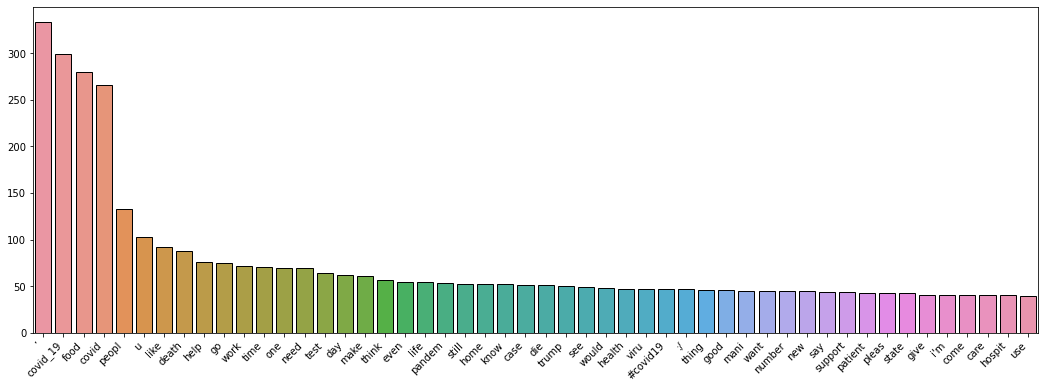

In [34]:
freq_list = freq_dist.most_common(50)

x = [tup[0] for tup in freq_list]
y = [tup[1] for tup in freq_list]

fig, ax = plt.subplots(1, 1, figsize = (18, 6))

sns.barplot(
    x = x,
    y = y,
    edgecolor = 'k',
)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

plt.show()

As you would suspect, the time required to complete the processing pipeline we have developed will depend on the type of texts and the number of texts we process. The following code bock shows how we can save the tokenized texts in the same format as the original data (JSON with GZIP compression). After execution, you will have a new file named `processed_tokens.json.gz` in the current directory that contains the processed texts in a list of lists.

In [35]:
# create Path object for file path
processed_tokens_path = pathlib.Path('processed_tokens.json.gz')

# "dump" the list of tokens to a JSON string
temp = json.dumps(tweet_tokens) + '\n' 

# encode the JSON string to bytes
json_bytes = json_str.encode('utf-8')

# open a GZIP file at the specified path
with gzip.GzipFile(processed_tokens_path, 'w') as fout:
    
    # write the bytes to the file object
    fout.write(json_bytes)    